## Generating image, finding different gradients of it, calculating module of the gradient and combining them into the new image

### The first task: create image with all the combinations of background and fill colours of three different shapes of figures

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9.0, 9.0)

In [3]:
from itertools import permutations

In [4]:
cell_size = 80

In [5]:
img = np.zeros((3 * cell_size, 6 * cell_size), dtype=np.uint8)

In [6]:
colors = [0, 128, 255]

In [7]:
figures = ['circle', 'triangle', 'rectangle']

In [8]:
def generate_cell(size, color):
    return np.zeros((cell_size, cell_size), dtype=np.uint8) + color

In [9]:
def draw_figure(cell, fig_type, color):
    if fig_type == 'circle':
        return cv2.circle(cell,(cell.shape[0] // 2, cell.shape[1] // 2), cell.shape[0] // 3, color, -1)
    elif fig_type == 'triangle':
        a = cell.shape[0] * 3 // 4
        h = a * np.sqrt(3) // 2
        pts = np.array([[a//2 ,0],[-a//2 ,0],[0, h]], np.int32) + np.array([cell.shape[0]//2, a//3])
        pts = pts.reshape((-1,1,2))
        return cv2.fillPoly(cell, [pts], color)
    elif fig_type == 'rectangle':
        return cv2.rectangle(cell,(cell.shape[0] // 4, cell.shape[1] // 4),
                             (cell.shape[0] * 3 // 4, cell.shape[1] * 3 // 4), color, cv2.FILLED)
    else:
        raise Exception('unsupported figure type')

In [10]:
def fill_image(img):
    iterator = permutations([0,1,2], 2)
    cells = []
    for pair in iterator:
        for figure in figures:
            cells.append(draw_figure(generate_cell(cell_size, colors[pair[0]]), figure, colors[pair[1]]))
    index = 0
    for y in range(0, 3 * cell_size, cell_size):
        for x in range(0, 6 * cell_size, cell_size):
            img[y:y+cell_size, x:x+cell_size] = cells[index]
            index += 1
    return img

In [11]:
res = fill_image(img)

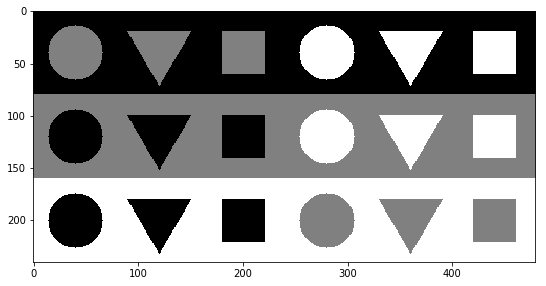

In [12]:
plt.imshow(res, cmap='gray')

### Task 2: Find gradient and its module

In [14]:
filter_1 = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
filter_2 = np.array([[-1,0,1],[-3,0,3],[-1,0,1]])

In [39]:
def apply_filter(img, kernel):
    grad1 = cv2.filter2D(img, -1, kernel)
    grad2 = cv2.filter2D(img, -1, kernel * -1)    
    grad3 = cv2.filter2D(img, -1, kernel.T)    
    grad4 = cv2.filter2D(img, -1, (kernel * -1).T)
    res = np.zeros((*img.shape, 4))
    res[:,:,0] = grad1
    res[:,:,1] = grad2    
    res[:,:,2] = grad3    
    res[:,:,3] = grad4   
    return res, grad1, grad4

In [40]:
def grad_module(grad):
    return np.apply_along_axis(lambda x: np.linalg.norm(x, ord=1), -1, grad)

In [42]:
gradients_merged, gradient_1, gradient_2 = apply_filter(res, filter_2)
module = grad_module(gradients_merged)

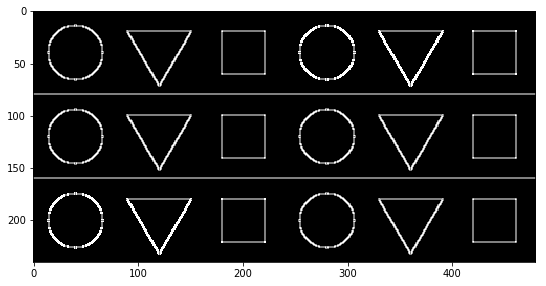

In [73]:
plt.imshow(module, cmap='gray')

In [71]:
hsv_gradients = np.zeros((*module.shape, 3), dtype=np.uint8)
hsv_gradients[:,:,0] = gradient_1 * 180 // 255
hsv_gradients[:,:,1] = gradient_2
hsv_gradients[:,:,2] = module * 255 // np.max(module)
rgb_gradients = cv2.cvtColor(hsv_gradients, cv2.COLOR_HSV2RGB)

In [72]:
print(module.shape)
print(gradients_merged.shape)
print(gradient_1.shape)
print(gradient_2.shape)
print(hsv_gradients.shape)
print(rgb_gradients.shape)

(240, 480)
(240, 480, 4)
(240, 480)
(240, 480)
(240, 480, 3)
(240, 480, 3)


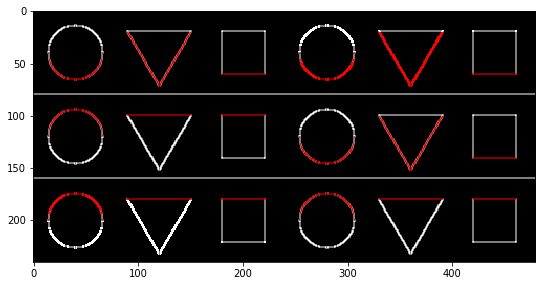

In [74]:
plt.imshow(rgb_gradients)